In [12]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures



from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

tf.__version__

'2.11.0'

In [13]:

#https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#0
#he Explainable AI SDK and Copy Model to Deploy

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb

In [14]:
#!gsutil cp gs://smart-ml-pongthorn/incident-train-data/TrainEval_Incident.csv data

In [42]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']
labelCol='Critical'
labelID='severity_id'
unusedCols=['severity_id','severity_name']

model_dir='critical_incident_dnn'

In [75]:
df = pd.read_csv('../data/TrainEval_Incident.csv')

sr_predict=df.iloc[-1,:]
df=df.iloc[0:len(df)-1,:]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2136 entries, 0 to 2135
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2136 non-null   int64  
 1   severity_name              2136 non-null   object 
 2   sla                        2136 non-null   object 
 3   product_type               2136 non-null   object 
 4   brand                      2136 non-null   object 
 5   service_type               2136 non-null   object 
 6   incident_type              2136 non-null   object 
 7   open_to_close_hour         2136 non-null   float64
 8   response_to_resolved_hour  2136 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 150.3+ KB
None


In [44]:
def map_4to2_serverity(severity_id):
    if severity_id==1 or severity_id==2:
       return 1
    else:
       return 0 
df[labelCol] =df[labelID].apply(map_4to2_serverity)

# df[labelCol] = df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3})

df =df.drop(columns=unusedCols)
       
nLabel=len(list(df[labelCol].unique()))

print(f"No target label : {nLabel}")


No target label : 2


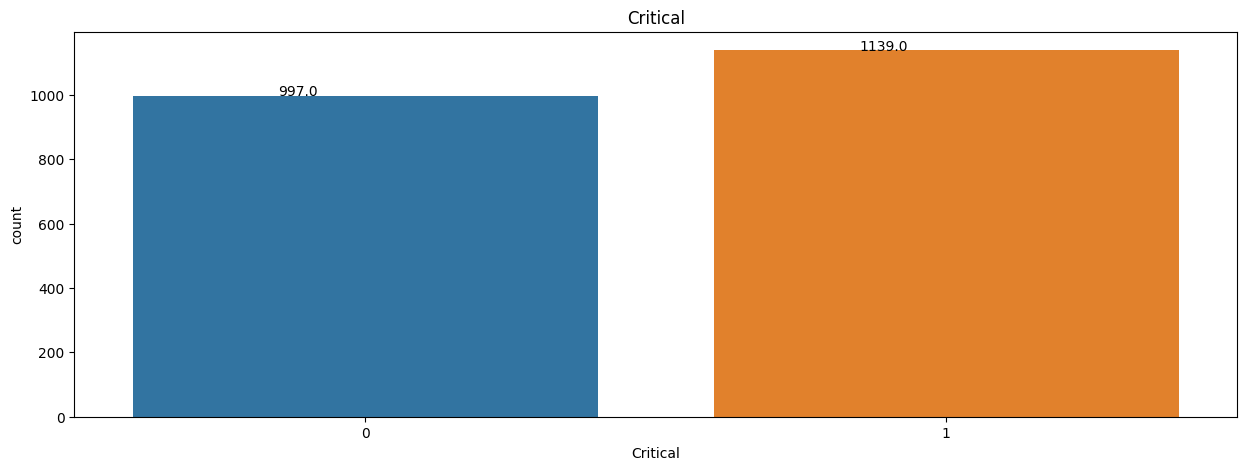

In [45]:
fig , ax = plt.subplots(figsize=(15,5))
ax =sns.countplot(x=labelCol, data=df,)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.title(labelCol.title())
plt.show()

In [46]:
df.tail()

,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,Critical
2131,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,4.166667,4.083333,1
2132,24x7 4Hrs Response Time,Software,VMWare,Incident,General Incident,6.433333,1.033333,0
2133,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Incident,General Incident,0.583333,0.350000,1
2134,24x7 4Hrs Resolution Time,Software,Red Hat,Incident,General Incident,119.433333,119.333333,1
2135,24x7 4Hrs Resolution Time,Server,Oracle,Incident,General Incident,23.500000,23.250000,1


In [47]:
sr_predict

severity_id                                          3
severity_name                                    Minor
sla                          24x7 4Hrs Resolution Time
product_type                                    Server
brand                                              HPE
service_type                                  Incident
incident_type                           Memory Failure
open_to_close_hour                           95.666667
response_to_resolved_hour                         95.5
Name: 2136, dtype: object

In [48]:
len_all=len(df)
print(f"All Data = {len_all}")

train, val = train_test_split(df,test_size=0.2)
val,test = train_test_split(val, test_size=0.5)

len_all=len(df)
len_train=len(train)
len_val=len(val)
len_test=len(test)
print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
print(f'{len_val} =val examples ({round(len_val/len_all*100,1)}%)')
print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')




All Data = 2136
1708 =train examples (80.0%)
214 =val examples (10.0%)
214 =test examples (10.0%)


In [49]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop(labelCol)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     

In [50]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [51]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('service_type:', train_features['service_type'])
print('incident_type:', train_features['incident_type'])
print('product_type:', train_features['product_type'])
print('open_to_close_hour:', train_features['open_to_close_hour'])
print(f'{labelCol} :{label_batch }')

Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
service_type: tf.Tensor([b'Incident' b'Incident' b'Request' b'Incident' b'Incident'], shape=(5,), dtype=string)
incident_type: tf.Tensor(
[b'Hard Disk Drive Failure' b'Software' b'General Incident'
 b'General Incident' b'General Incident'], shape=(5,), dtype=string)
product_type: tf.Tensor([b'Storage' b'Software' b'Storage' b'Software' b'Storage'], shape=(5,), dtype=string)
open_to_close_hour: tf.Tensor(
[8.99166667e+01 5.20000000e+00 1.44230000e+03 3.02333333e+01
 1.20000000e+00], shape=(5,), dtype=float64)
Critical :[1 1 0 0 1]


In [52]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [53]:
hour_col = train_features['open_to_close_hour']
layer = get_normalization_layer('open_to_close_hour', train_ds)
layer(hour_col)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.00933218, -0.33942586,  5.260153  , -0.24188489, -0.35501164],
      dtype=float32)>

In [54]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [55]:
# total no type+unkonw
type_col = train_features['product_type']
layer = get_category_encoding_layer('product_type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [56]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [57]:
all_inputs = []
encoded_features = []

In [58]:
# Numeric features.
for header in numbericCols:
  print(header)  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

open_to_close_hour
response_to_resolved_hour


In [59]:
# Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


sla
product_type
brand
service_type
incident_type


In [63]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(16, activation="relu")(all_features)
# x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(16, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(1)(x)
# output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

model = tf.keras.Model(all_inputs, output)


# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]


model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=["accuracy"])
     

In [64]:
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sla (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 product_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 brand (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 service_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                            

In [67]:
EPOCHS = 150
BATCH_SIZE = 32


# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1)
# history =model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks = [early_stopping])
history =model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE)


Epoch 1/150
7/7 [==============================] - 0s 8ms/step - loss: 0.3598 - accuracy: 0.8226 - val_loss: 0.4836 - val_accuracy: 0.7850
Epoch 2/150
7/7 [==============================] - 0s 7ms/step - loss: 0.3593 - accuracy: 0.8214 - val_loss: 0.4831 - val_accuracy: 0.7850
Epoch 3/150
7/7 [==============================] - 0s 7ms/step - loss: 0.3585 - accuracy: 0.8232 - val_loss: 0.4846 - val_accuracy: 0.7897
Epoch 4/150
7/7 [==============================] - 0s 8ms/step - loss: 0.3581 - accuracy: 0.8232 - val_loss: 0.4851 - val_accuracy: 0.7897
Epoch 5/150
7/7 [==============================] - 0s 9ms/step - loss: 0.3577 - accuracy: 0.8208 - val_loss: 0.4857 - val_accuracy: 0.7804
Epoch 6/150
7/7 [==============================] - 0s 9ms/step - loss: 0.3583 - accuracy: 0.8226 - val_loss: 0.4857 - val_accuracy: 0.7897
Epoch 7/150
7/7 [==============================] - 0s 8ms/step - loss: 0.3569 - accuracy: 0.8226 - val_loss: 0.4878 - val_accuracy: 0.7850
Epoch 8/150
7/7 [==========

In [69]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
     

1/1 [==============================] - 0s 22ms/step - loss: 0.4366 - accuracy: 0.8037
Accuracy 0.8037382960319519


In [70]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [72]:
model.save(model_dir)


INFO:tensorflow:Assets written to: critical_incident_dnn\assets


INFO:tensorflow:Assets written to: critical_incident_dnn\assets


In [73]:
reloaded_model = tf.keras.models.load_model(model_dir)
sample=sr_predict.to_dict()
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])
print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)
                                

D:\ProgramData\Anaconda3\envs\dev_google\lib\site-packages\keras\engine\functional.py:638: UserWarning: Input dict contained keys ['severity_id', 'severity_name'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 0s 300ms/step
This particular pet had a 93.9 percent probability of getting adopted.


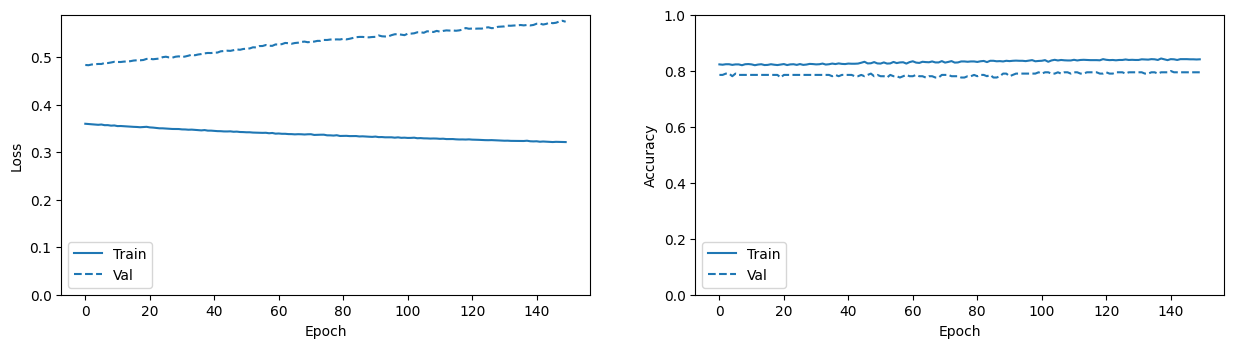

In [74]:
plt.figure(figsize=(15,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [349]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
import explainable_ai_sdk

model_builder = SavedModelMetadataBuilder(model_dir)
metadata = model_builder.get_metadata()
print(metadata)

{'outputs': OrderedDict([('dense_38', {'output_tensor_name': 'dense_38'})]), 'inputs': OrderedDict([('response_to_resolved_hour', {'input_tensor_name': 'response_to_resolved_hour', 'encoding': 'identity', 'modality': 'numeric'}), ('open_to_close_hour', {'input_tensor_name': 'open_to_close_hour', 'encoding': 'identity', 'modality': 'numeric'}), ('incident_type', {'input_tensor_name': 'incident_type', 'encoding': 'identity', 'modality': 'categorical'}), ('sla', {'input_tensor_name': 'sla', 'encoding': 'identity', 'modality': 'categorical'}), ('product_type', {'input_tensor_name': 'product_type', 'encoding': 'identity', 'modality': 'categorical'}), ('brand', {'input_tensor_name': 'brand', 'encoding': 'identity', 'modality': 'categorical'}), ('service_type', {'input_tensor_name': 'service_type', 'encoding': 'identity', 'modality': 'categorical'})]), 'framework': 'tensorflow2', 'tags': ['explainable_ai_sdk']}


In [383]:
# Update these to your own GCP project and model
PROJECT_ID = 'pongthorn'
REGION = "asia-southeast1"  # @param {type: "string"}
MODEL_BUCKET = 'gs://tf1-incident-pongthorn'

!gsutil mb -l$REGION $MODEL_BUCKET

Creating gs://tf1-incident-pongthorn/...


In [384]:
!gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/model

Copying file://.\critical_incident_dnn\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/505.0 KiB]   0% Done                                    
Copying file://.\critical_incident_dnn\fingerprint.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/505.0 KiB]   0% Done                                    
Copying file://.\critical_incident_dnn\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/505.0 KiB]   0% Done                                    
Copying file://.\critical_incident_dnn\saved_model.pb [Content-Type=application/octet-stream]...
Copying file://.\critical_incident_dnn\keras_metadata.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/505.0 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/505.0 KiB]   0% Done                                    
/ [1/5 files][ 73.2 KiB/505.0 KiB]  14% Done                           

# Deploy the model

In [385]:
MODEL = 'tf1_incident'
VERSION = 'v1'
model_path = MODEL_BUCKET + '/model'

In [392]:
# !gcloud ai-platform models create $MODEL --region=$REGION